# Classification: premier modèle avec les SVM

``` python
import sys
sys.path.insert(1, '../../../../') #insert the utils module
from utils import print_badges

#print_badges(__file__)
print_badges("content/course/modelisation/2_SVM.qmd")
```

<p class="badges">

<a href="https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/2_SVM.ipynb" class="github"><i class="fab fa-github"></i></a>
<a href="https://downgit.github.io/#/home?url=https://github.com/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/2_SVM.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Download-Notebook-important?logo=Jupyter" alt="Download"></a>
<a href="https://nbviewer.jupyter.org/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/2_SVM.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Visualize-nbviewer-blue?logo=Jupyter" alt="nbviewer"></a>
<a href="https://datalab.sspcloud.fr/launcher/ide/jupyter-python?autoLaunch=true&onyxia.friendlyName=%C2%ABpython-datascience%C2%BB&init.personalInit=%C2%ABhttps%3A%2F%2Fraw.githubusercontent.com%2Flinogaliana%2Fpython-datascientist%2Fmaster%2Fsspcloud%2Finit-jupyter.sh%C2%BB&init.personalInitArgs=%C2%ABmodelisation%202_SVM%C2%BB&security.allowlist.enabled=false" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/SSPcloud-Tester%20via%20SSP--cloud-informational&amp;color=yellow?logo=Python" alt="Onyxia"></a><br>
<a href="https://mybinder.org/v2/gh/linogaliana/python-datascientist/master?filepath={binder_path}" target="_blank" rel="noopener"><img src="https://img.shields.io/badge/Launch-Binder-E66581.svg?logo=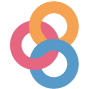" alt="Binder"></a>
<a href="http://colab.research.google.com/github/linogaliana/python-datascientist/blob/master/notebooks/course/modelisation/2_SVM.ipynb" target="_blank" rel="noopener"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
<a href="https://github.dev/linogaliana/python-datascientist/notebooks/course/modelisation/2_SVM.ipynb" target="_blank" rel="noopener"><img src="https://img.shields.io/static/v1?logo=visualstudiocode&label=&message=Open%20in%20Visual%20Studio%20Code&labelColor=2c2c32&color=007acc&logoColor=007acc" alt="githubdev"></a>

</p>

</p>

Nous allons partir du même jeu de données que précédemment,
c’est-à-dire les résultats des élections US 2020 présentés dans l’[introduction
de cette partie](https://linogaliana-teaching.netlify.app/modelisation/): les données de vote aux élections présidentielles américaines
croisées à des variables sociodémographiques.
Le code
est disponible [sur Github](https://github.com/linogaliana/python-datascientist/blob/master/content/course/modelisation/get_data.py).

In [2]:
#!pip install --upgrade xlrd #colab bug verson xlrd
#!pip install geopandas

import requests

url = 'https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/course/modelisation/get_data.py'
r = requests.get(url, allow_redirects=True)
open('getdata.py', 'wb').write(r.content)

import getdata
votes = getdata.create_votes_dataframes()

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning:

The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.


ERROR 1: PROJ: proj_create_from_database: Open of /miniconda/envs/python-ENSAE/share/proj failed

Pour ce TP, nous aurons besoin des packages suivants :

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

## La méthode des SVM (Support Vector Machines)

L’une des méthodes de *Machine Learning* les plus utilisées en classification est les SVM.
Il s’agit de trouver, dans un système de projection adéquat (noyau ou *kernel*),
les paramètres de l’hyperplan (en fait d’un hyperplan à marges maximales)
séparant les classes de données:

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_iris_svc_001.png)

::: {.cell .markdown}

On peut, sans perdre de généralité, supposer que le problème consiste à supposer l’existence d’une loi de probabilité $\mathbb{P}(x,y)$ ($\mathbb{P} \to \{-1,1\}$) qui est inconnue. Le problème de discrimination
vise à construire un estimateur de la fonction de décision idéale qui minimise la probabilité d’erreur, autrement dit $\theta = \arg\min_\Theta \mathbb{P}(h_\theta(X) \neq y |x)$

Les SVM les plus simples sont les SVM linéaires. Dans ce cas, on suppose qu’il existe un séparateur linéaire qui permet d’associer chaque classe à son signe:

$$
h_\theta(x) = \text{signe}(f_\theta(x)) ; \text{ avec } f_\theta(x) = \theta^T x + b
$$

avec $\theta \in \mathbb{R}^p$ et $w \in \mathbb{R}$.

![](https://en.wikipedia.org/wiki/File:SVM_margin.png)

Lorsque des observations sont linéairement séparables, il existe une infinité de frontières de décision linéaire séparant les deux classes. Le “meilleur” choix est de prendre la marge maximale permettant de séparer les données. La distance entre les deux marges est $\frac{2}{||\theta||}$. Donc maximiser cette distance entre deux hyperplans revient à minimiser $||\theta||^2$ sous la contrainte $y_i(\theta^Tx_i + b) \geq 1$.

Dans le cas non linéairement séparable, la *hinge loss* $\max\big(0,y_i(\theta^Tx_i + b)\big)$ permet de linéariser la fonction de perte:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b5/Hinge_loss_vs_zero_one_loss.svg/1024px-Hinge_loss_vs_zero_one_loss.svg.png)

ce qui donne le programme d’optimisation suivant:

$$
\frac{1}{n} \sum_{i=1}^n \max\big(0,y_i(\theta^Tx_i + b)\big) + \lambda ||\theta||^2
$$

La généralisation au cas non linéaire implique d’introduire des noyaux transformant l’espace de coordonnées des observations.

</div>

In [4]:
import requests
import shutil

url = 'https://dataanalyticspost.com/wp-content/uploads/2018/01/img_svm.png'
response = requests.get(url, stream=True)
with open('featured.png', 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)

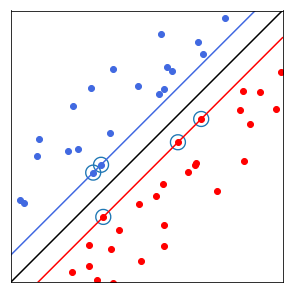

## Exercice

In [5]:
# packages utiles
from sklearn import svm
import sklearn.metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

::: {.cell .markdown}

1.  Créer une variable *dummy* appelée `y` dont la valeur vaut 1 quand les républicains l’emportent.
2.  En utilisant la fonction prête à l’emploi nommée `train_test_split` de la librairie `sklearn.model_selection`,
    créer des échantillons de test (20 % des observations) et d’estimation (80 %) avec comme *features*: `'Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"` et comme *label* la variable `y`.

> A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

*Note : Pour éviter ce warning à chaque fois que vous estimez votre modèle, vous pouvez utiliser `DataFrame[['y']].values.ravel()` plutôt que `DataFrame[['y']]` lorsque vous constituez vos échantillons.*

1.  Entraîner un classifieur SVM avec comme paramètre de régularisation `C = 1`. Regarder les mesures de performance suivante : `accuracy`, `f1`, `recall` et `precision`.

2.  Vérifier la matrice de confusion : vous devriez voir que malgré des scores en apparence pas si mauvais, il y a un problème notable.

3.  Refaire les questions précédentes avec des variables normalisées. Le résultat est-il différent ?

4.  Changer de variables *x*. Utiliser uniquement le résultat passé du vote démocrate et le revenu (`votes_gop` et `Median_Household_Income_2019`). Regarder les résultats, notamment la matrice de confusion.

5.  \[OPTIONNEL\] Faire une 5-fold validation croisée pour déterminer le paramètre *C* idéal.

::: {.cell .markdown}

In [6]:
# 1. Création de la dummy y de victoire des républicains
votes['y'] = (votes['votes_gop'] > votes['votes_dem']).astype(int)

In [7]:
#2. Création des échantillons d'entraînement et de validation
xvars = ['Unemployment_rate_2019', 'Median_Household_Income_2019', 'Percent of adults with less than a high school diploma, 2015-19', "Percent of adults with a bachelor's degree or higher, 2015-19"]

df = votes[["y"] + xvars]

X_train, X_test, y_train, y_test = train_test_split(
    df[xvars],
    df[['y']].values.ravel(), test_size=0.2, random_state=0
)
#X_train.head()
#y_test


In [8]:
# 3. Entraînement du modèle et performances
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)

sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
sc_f1 = sklearn.metrics.f1_score(y_pred, y_test)
sc_recall = sklearn.metrics.recall_score(y_pred, y_test)
sc_precision = sklearn.metrics.precision_score(y_pred, y_test)

#print(sc_accuracy)
#print(sc_f1)
#print(sc_recall)
#print(sc_precision)

Le classifieur avec `C = 1` devrait avoir les performances suivantes:

``` python
out = pd.DataFrame.from_dict({"Accuracy": [sc_accuracy], "Recall": [sc_recall],
                        "Precision": [sc_precision], "F1": [sc_f1]}, orient = "index", columns = ["Score"])
print(out.to_markdown())
```

|           |    Score |
|:----------|---------:|
| Accuracy  | 0.868167 |
| Recall    | 0.878307 |
| Precision |  0.97456 |
| F1        | 0.923933 |

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


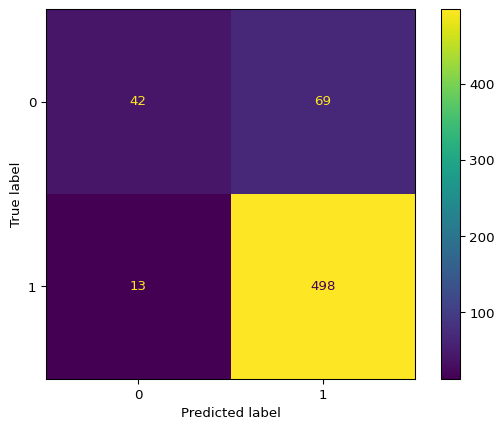

In [10]:
# 4. Matrice de confusion
sklearn.metrics.plot_confusion_matrix(clf, X_test, y_test)

#Réponse : Notre classifieur manque totalement les labels 0, qui sont minoritaires.
#Une raison possible ? L'échelle des variables: le revenu a une
#distribution qui peut écraser celle des autres variables,
#dans un modèle linéaire. Il faut donc, a minima, 
#standardiser les variables.

plt.savefig("confusion_matrix.png")

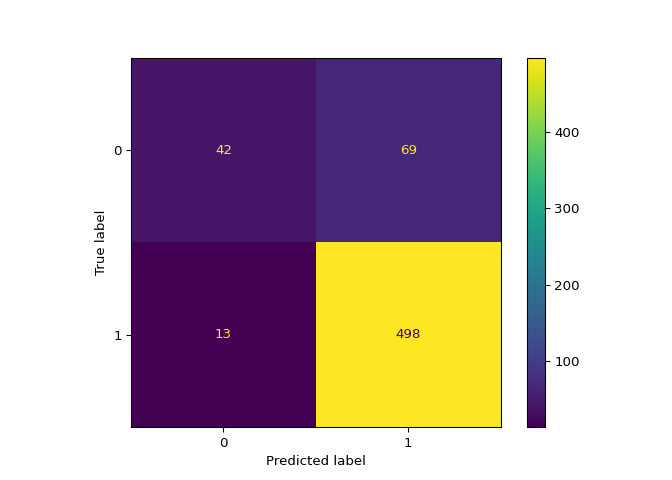

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


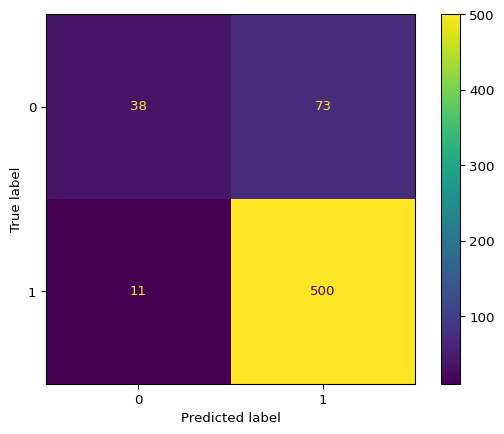

In [11]:
# 5. Refaire les questions précédentes avec des variables normalisées.
import sklearn.preprocessing as preprocessing

X = df[xvars]
y = df[['y']]
scaler = preprocessing.StandardScaler().fit(X) #Ici on standardise
X = scaler.transform(X) #Ici on standardise

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y.values.ravel(), test_size=0.2, random_state=0
)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)
sklearn.metrics.plot_confusion_matrix(clf, X_test, y_test)

#Réponse : Non, standardiser les variables n'apporte pas de gain
# Il faut donc aller plus loin : le problème ne vient pas de l'échelle mais du choix des variables. 
# C'est pour cette raison que l'étape de sélection de variable est cruciale.

plt.savefig("confusion_matrix2.png")

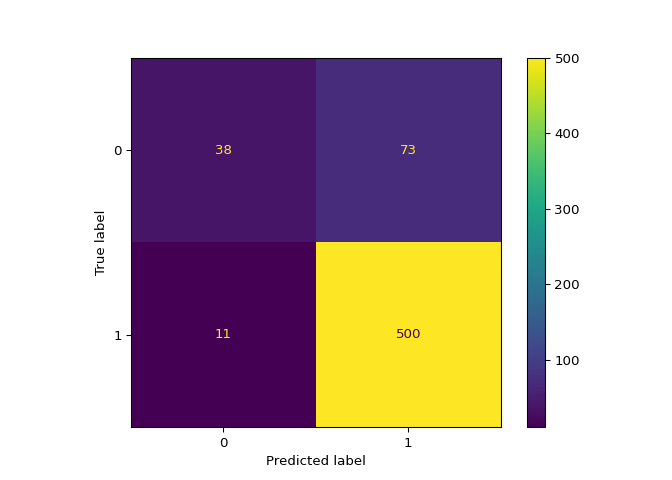

A l’issue de la question 6,
le nouveau classifieur avec devrait avoir les performances suivantes :

``` python
out = pd.DataFrame.from_dict({"Accuracy": [sc_accuracy], "Recall": [sc_recall],
                        "Precision": [sc_precision], "F1": [sc_f1]}, orient = "index", columns = ["Score"])
print(out.to_markdown())
```

|           |    Score |
|:----------|---------:|
| Accuracy  | 0.868167 |
| Recall    | 0.878307 |
| Precision |  0.97456 |
| F1        | 0.923933 |

/miniconda/envs/python-ENSAE/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.


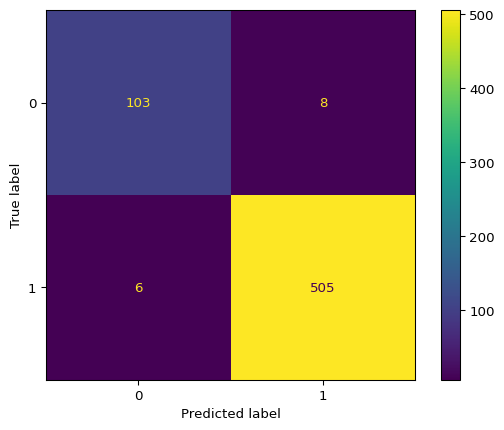

In [13]:
# 6. Refaire les questions en changeant la variable X.
votes['y'] = (votes['votes_gop'] > votes['votes_dem']).astype(int)
df = votes[["y", "share_2016_republican", 'Median_Household_Income_2019']]
tempdf = df.dropna(how = "any")

X = votes[['share_2016_republican', 'Median_Household_Income_2019']]
y = tempdf[['y']]
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y.values.ravel(), test_size=0.2, random_state=0
)

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
y_pred = clf.predict(X_test)

sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
sc_f1 = sklearn.metrics.f1_score(y_pred, y_test)
sc_recall = sklearn.metrics.recall_score(y_pred, y_test)
sc_precision = sklearn.metrics.precision_score(y_pred, y_test)

#print(sc_accuracy)
#print(sc_f1)
#print(sc_recall)
#print(sc_precision)

sklearn.metrics.plot_confusion_matrix(clf, X_test, y_test)
# On obtient un résultat beaucoup plus cohérent.

plt.savefig("confusion_matrix3.png")

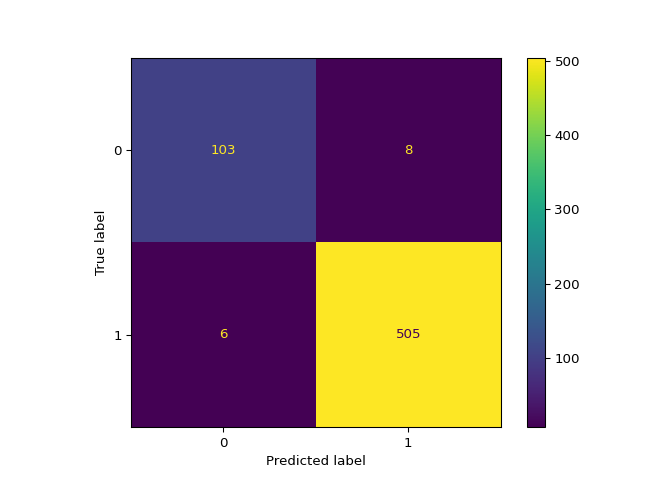

In [14]:
# TODO : correction à rédiger.